In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container {width:90% !important;}</style>"))

In [2]:
%matplotlib notebook

from numpy import *
import os
from os import path
home = path.expanduser("~")

from matplotlib import animation
import matplotlib.pyplot as plt

# define format for the plots
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [6., 4.5]
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.8
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = "in"
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.8
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.direction'] = "in"
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['font.size'] = 15
mpl.rcParams['savefig.format'] = "pdf"

working_path = os.getcwd()

In [3]:
# define the contour levels
levels = linspace(0.13, 0.30, 50)

# define a custmized color map
colors1 = array([[1, 1, 1, 1]])
colors2 = plt.cm.jet(linspace(0., 1, 10))
colors = vstack((colors1, colors2))
my_cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', colors)

In [4]:
results_path = os.path.dirname(working_path)

In [5]:
plots_path = path.join(os.path.dirname(working_path), "plots")

In [6]:
exercise_path = "run_exercise_2"

# Read in hydro results

## hydro evolution

In [7]:
# load hydrodynamic evolution data
data = fromfile(path.join(results_path, exercise_path, "evolution_all_xyeta_MUSIC.dat"), dtype=float32)

In [8]:
# read header about the grid information
header = data[0:16]

# read in data and reshape it to the correct form
data = data[16:].reshape(-1, int(header[-1]))

# get the list for tau frame
tau_list = unique(data[:, 0])
ntau = len(tau_list)
tau0= header[0]; dtau = header[1];
tau_list = array([tau0 + i*dtau for i in range(ntau)])

# define 3D grid in x, y, and eta_s (space-time rapidity)
neta = int(header[8])
eta_size = -2.*header[10]
deta = header[9]
eta = array([-eta_size/2.+i*deta for i in range(neta)])

nx = int(header[2])
x_size = 2.*abs(header[4])
dx = header[3]
x = array([-x_size/2.+i*dx for i in range(nx)])

ny = int(header[5])
y_size = 2.*abs(header[7])
dy = header[6]
y = array([-y_size/2.+i*dy for i in range(ny)])

# create 3D grids for energy density, temperature, and velocity
ed = zeros([ntau, neta, nx, ny])
T  = zeros([ntau, neta, nx, ny])
vx = zeros([ntau, neta, nx, ny])
vy = zeros([ntau, neta, nx, ny])
for itau in range(ntau):
    idx = (abs(data[:, 0] - itau) < 0.05)
    data_cut = data[idx, :]
    for igrid in range(len(data_cut[:, 0])):
        x_idx   = int(data_cut[igrid, 1] + 0.1)
        y_idx   = int(data_cut[igrid, 2] + 0.1)
        eta_idx = int(data_cut[igrid, 3] + 0.1)
        u0 = sqrt(1. + data_cut[igrid, 8]**2.
                  + data_cut[igrid, 9]**2. + data_cut[igrid, 10]**2)
        ed[itau, eta_idx, x_idx, y_idx] = data_cut[igrid, 4]
        T[itau, eta_idx, x_idx, y_idx]  = data_cut[igrid, 6]
        vx[itau, eta_idx, x_idx, y_idx] = data_cut[igrid, 8]/u0
        vy[itau, eta_idx, x_idx, y_idx] = data_cut[igrid, 9]/u0

## freeze-out surface

In [9]:
# load hydrodynamic evolution data
fzout_results = fromfile(path.join(results_path, exercise_path, "surface_MUSIC.dat"), dtype=float32)
fz_results = fzout_results.reshape(-1, 34)
fz_len = len(fz_results)

In [10]:
tau_fz = []
xc_fz = []
yc_fz = []

xc_fz1 = []
yc_fz1 = []

tau_fz2 = []
xc_fz2 = []

for i in range(fz_len):
    
    tau = fz_results[i,0]
    xc  = fz_results[i,1]
    yc  = fz_results[i,2]
    
    tau_fz.append([tau])
    xc_fz.append([xc])
    yc_fz.append([yc])
    
    if abs(tau-tau0)<0.02:

        xc_fz1.append([xc])
        yc_fz1.append([yc])
        
    if abs(yc)<0.5: # to include fluid cells on the phase transition line

        tau_fz2.append([tau])
        xc_fz2.append([xc])

# Make hydro evolution plots

## 3D scatter plot for the freeze-out surface

<IPython.core.display.Javascript object>


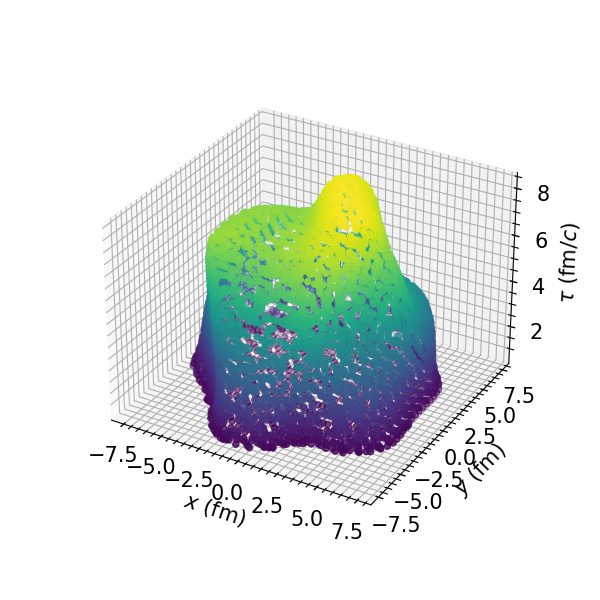

In [11]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

nSkip = 3

ax.scatter(xc_fz[::nSkip], yc_fz[::nSkip], tau_fz[::nSkip], c=tau_fz[::nSkip])
ax.set_xlabel(r"$x$ (fm)")
ax.set_ylabel(r"$y$ (fm)")
ax.set_zlabel(r"$\tau$ (fm/$c$)")
ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])
ax.set_zlim([tau0, 8.5])
plt.savefig(path.join(plots_path, "{0}_freezeout_surface").format(exercise_path))

## Make a 2D contour plot for initial temperature distribution in the transverse plane

<IPython.core.display.Javascript object>


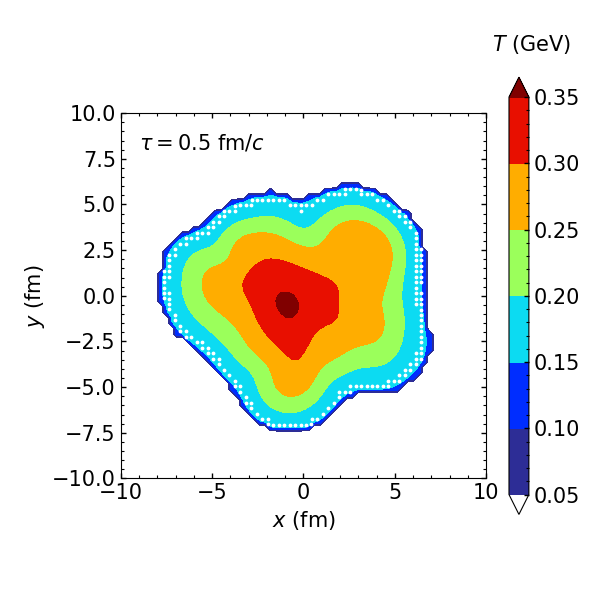

In [12]:
# make a 2D meshgrid in the transverse plane
Y, X = meshgrid(y, x)

t_idx = 0
# make the contour plot
fig = plt.figure(figsize=(6,6))
cont = plt.contourf(X, Y, T[t_idx, 0, :, :], cmap=my_cmap, extend='both')
cbar = fig.colorbar(cont, shrink=0.8)
cbar.set_label(r"$T$ (GeV)", labelpad=-35, y=1.1, rotation=0)
plt.scatter(xc_fz1, yc_fz1, c='w', s=3)
plt.text(-9, 8, r'$\tau = {0:3.1f}$ fm/$c$'.format(tau_list[t_idx]))
plt.xlabel(r"$x$ (fm)")
plt.ylabel(r"$y$ (fm)")
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig(path.join(plots_path, "{0}_Temperature_Contour_XY").format(exercise_path))

## A 2D contour plot for $\tau$ vs x.

<IPython.core.display.Javascript object>


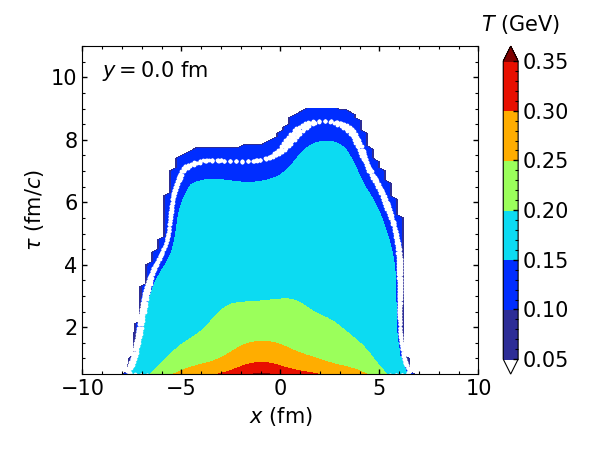

In [13]:
X, Tau = meshgrid(x, tau_list)

y_idx = int(ny/2)  # pick the central point in the y direction

fig = plt.figure(figsize=(6,4.5))
cont = plt.contourf(X, Tau, T[:, 0, :, y_idx], cmap=my_cmap, extend='both')
cbar = fig.colorbar(cont)
cbar.set_label(r"$T$ (GeV)", labelpad=-35, y=1.1, rotation=0)
plt.scatter(xc_fz2, tau_fz2, c='w', s=3)
plt.ylabel(r"$\tau$ (fm/$c$)")
plt.xlabel(r"$x$ (fm)")
plt.xlim([-10, 10])
plt.ylim([tau0, 11])
plt.text(-9, 10, r'$y = {0:3.1f}$ fm'.format(y[y_idx]))
plt.tight_layout()
plt.savefig(path.join(plots_path, "{0}_Temperature_Contour_TauX").format(exercise_path))

## Generate a movie for temperature profile

<IPython.core.display.Javascript object>


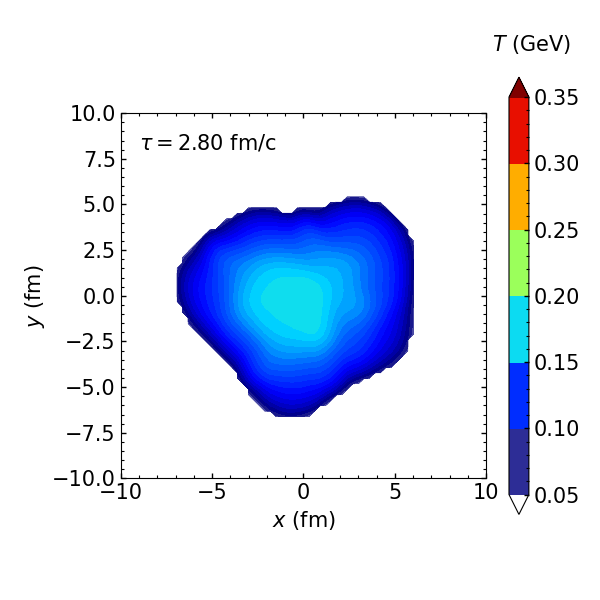

In [14]:
Y, X = meshgrid(y, x)

# first plot the first frame as a contour plot
fig = plt.figure(figsize=(6,6))
cont = plt.contourf(X, Y, T[0, 0, :, :], cmap=my_cmap, extend='both')
time_text = plt.text(-9, 8, r"$\tau = {0:4.2f}$ fm/c".format(tau_list[0]))
cbar = fig.colorbar(cont, shrink=0.8)
cbar.set_label(r"$T$ (GeV)", labelpad=-35, y=1.1, rotation=0)
plt.xlabel(r"$x$ (fm)")
plt.ylabel(r"$y$ (fm)")
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.gca().set_aspect('equal')
plt.tight_layout()

# define animation function to update the contour at every time frame
def animate(i): 
    global cont, time_text
    for c in cont.collections:
        c.remove()  # removes only the contours, leaves the rest intact
    cont = plt.contourf(X, Y, T[i, 0, :, :], levels, cmap=my_cmap, extend='both')
    time_text.set_text(r"$\tau = {0:4.2f}$ fm/c".format(tau_list[i]))
    return cont, time_text

# create the animation
anim = animation.FuncAnimation(fig, animate, frames=ntau, repeat=False)

## Generate movie for temperature evolution with velocity field

<IPython.core.display.Javascript object>


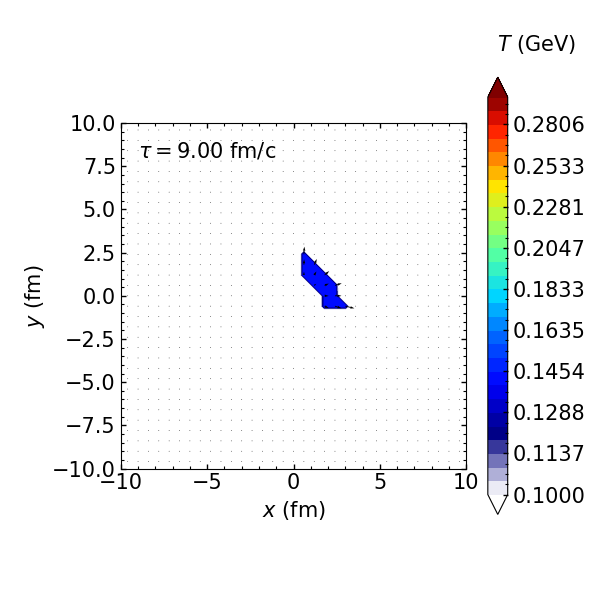

In [16]:
nskip = 2  # only plot every other point to speed up the live animation

Y, X = meshgrid(y, x)

v_mag = sqrt(vx[-1, 0, :, :]**2 + vy[-1, 0, :, :]**2.)

# first plot the first frame as the contour plot
levels2 = (linspace(0.10**0.25, 0.3**0.25, 30))**(4.)
fig = plt.figure(figsize=(6,6))
cont = plt.contourf(X[::nskip, ::nskip], Y[::nskip, ::nskip],
                    T[0, 0, ::nskip, ::nskip],
                    levels2, cmap=my_cmap, extend='both')
Q = plt.quiver(X[::nskip, ::nskip], Y[::nskip, ::nskip],
              vx[0, 0, ::nskip, ::nskip],
              vy[0, 0, ::nskip, ::nskip],
              units='xy', scale_units='xy', scale=0.5, color='k')
time_text = plt.text(-9, 8, r"$\tau = {0:4.2f}$ fm/c".format(tau_list[0]))
cbar = fig.colorbar(cont, shrink=0.8)
cbar.set_label(r"$T$ (GeV)", labelpad=-35, y=1.1, rotation=0)
plt.xlabel(r"$x$ (fm)")
plt.ylabel(r"$y$ (fm)")
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.gca().set_aspect('equal')
plt.tight_layout()

# update the temperature contour and velocity vector field 
def update_quiver(num, X, Y):
    global Q, cont, time_text
    Q.remove()
    for c in cont.collections:
        c.remove()  # removes only the contours, leaves the rest intact
    cont = plt.contourf(X[::nskip, ::nskip], Y[::nskip, ::nskip],
                        T[num, 0, ::nskip, ::nskip],
                        levels2, cmap=my_cmap, extend='both')
    time_text.set_text(r"$\tau = {0:4.2f}$ fm/c".format(tau_list[num])) 
    
    U = vy[num, 0, ::nskip, ::nskip]
    V = vx[num, 0, ::nskip, ::nskip]
    
    Q = plt.quiver(X[::nskip, ::nskip], Y[::nskip, ::nskip],
                   V, U, units='xy', scale_units='xy', scale=0.5, color='k')
    return Q, cont, time_text  

# create the animation
anim = animation.FuncAnimation(fig, update_quiver, fargs=(X, Y),
                               frames=ntau, blit=False, repeat=False)

# to save the animation, need to install FFmpeg, off by default
#anim.save(path.join(plots_path, '{0}_animation_Tandflow.mp4').format(exercise_path), fps=10, writer="ffmpeg")